# Example: Minimization Tool in PyRayHF
In this example, we start with a given background ionospheric model. 
We modify this background to create synthetic data and then use a minimization 
technique to adjust the background so that it matches the synthetic data.

In [4]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of a minimization tool in PyRayHF.
"""

import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import PyRayHF

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_example = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
# Consider this the model background for the upcoming minimization.
mode = 'O'
n_points = 200

# Produce background data, or the observations expected by the background
vh_back, EDP_back = PyRayHF.library.model_VH(input_example['F2'],
                                             input_example['F1'],
                                             input_example['E'],
                                             input_example['freq'],
                                             input_example['alt'],
                                             input_example['bmag'],
                                             input_example['bpsi'])

# Create a known "truth" by modifying the background parameters:
# increase Nm by 20%, decrease hm by 20%, and increase B_bot by 10%.
# This generates synthetic data. Note that the F1 layer depends on F2
# and will change accordingly.
F2_truth = deepcopy(input_example['F2'])
F2_truth['Nm'] = F2_truth['Nm'] * 1.2
F2_truth['hm'] = F2_truth['hm'] * 0.8
F2_truth['B_bot'] = F2_truth['B_bot'] * 1.1
vh_data, EDP_truth = PyRayHF.library.model_VH(F2_truth,
                                              input_example['F1'],
                                              input_example['E'],
                                              input_example['freq'],
                                              input_example['alt'],
                                              input_example['bmag'],
                                              input_example['bpsi'])

# Filter out NaNs in the synthetic data before minimization.
# Minimization will not work properly if NaNs are present.
ind_valid = np.where(np.isfinite(vh_data) == 1)[0]
freq_in = input_example['freq'][ind_valid]
vh_in = vh_data[ind_valid]

# Using brute-force optimization to find F2-layer parameters that best
# reproduce the synthetic virtual height observations.
# The method searches over a range of values with a 30% perturbation
# margin and step size of 1 km.
(vh_result,
 EDP_result) = PyRayHF.library.minimize_parameters(input_example['F2'],
                                                   input_example['F1'],
                                                   input_example['E'],
                                                   freq_in,
                                                   vh_in,
                                                   input_example['alt'],
                                                   input_example['bmag'],
                                                   input_example['bpsi'],
                                                   method='brute',
                                                   percent_sigma=20.,
                                                   step=2.)

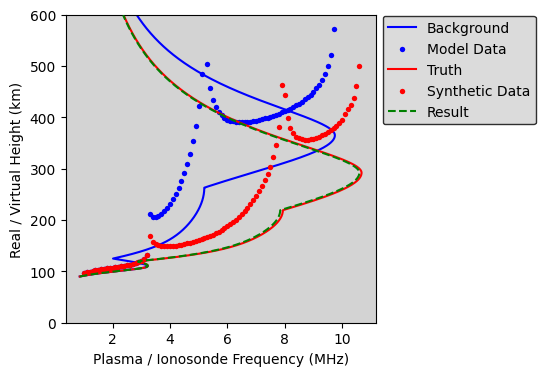

In [5]:
# Plot the results.
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency and plotted using real altitude on the y-axis.
# Virtual heights for O-mode are plotted with ionosonde frequency on
# the x-axis and virtual height on the y-axis.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 600])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real / Virtual Height (km)')
ax.set_xlabel('Plasma / Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(input_example['den']) / 1e6,
        input_example['alt'], c='blue', label='Background', zorder=1)
ax.scatter(input_example['freq'], vh_back, c='blue', label='Model Data',
           zorder=1, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6,
        input_example['alt'], c='red', label='Truth', zorder=2)
ax.scatter(input_example['freq'], vh_data, c='red', label='Synthetic Data',
           zorder=2, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_result) / 1e6,
        input_example['alt'], '--', c='green', label='Result', zorder=3)
leg = plt.legend(bbox_to_anchor=(1.0, 1.02), facecolor='lightgray', frameon=True)
leg.get_frame().set_edgecolor('black')
plt.savefig('/Users/victoriyamakarevich/Documents/GitHub/PyRayHF/docs/figures/Minimization.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()